
## Challenge: Boston Marathon
There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Use the tools at hand to determine which clustering solution,
Including number of clusters and algorithm used is best for the marathon data.
Once you have a solution you like:

Write a data story, including visualizations
Teach the reader something about the Boston Marathon based on your clusters.
Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

In [1]:
##Imports
## Standard toolkit
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Make Data
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split

#Pre-Processing
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Clustering Algos
# k-means,Mean-Shift, Spectral, Affinity
from sklearn.cluster import KMeans,MeanShift, estimate_bandwidth,SpectralClustering,AffinityPropagation

#Metrics
from sklearn import metrics

#import cycle
from itertools import cycle

In [2]:
#Display all the columns
pd.set_option('display.max_columns', 500)
df = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')
df.head()

10k                name  division    25k gender  age  official bib  \
0  17.37  Yamamoto, Hiroyuki         8  47.67      M   47     85.25  W1   
1  32.58        Jeptoo, Rita         1  82.43      F   33    138.95  F1   
2  16.62   Van Dyk, Ernst F.         1  45.80      M   41     80.60  W2   
3  32.57        Dibaba, Mare         3  82.43      F   24    140.58  F2   
4  17.12      Hokinoue, Kota         2  46.37      M   40     81.23  W3   

   genderdiv  ctz     35k  overall  pace state    30k     5k   half    20k  \
0          8  NaN   71.40        8  3.27   NaN  59.18   8.02  39.72  37.65   
1          1  NaN  116.37       21  5.30   NaN  99.33  16.22  69.47  65.83   
2          1  NaN   67.42        1  3.08   NaN  56.45   7.75  38.03  36.10   
3          3  NaN  116.37       27  5.37   NaN  99.33  16.20  69.47  65.83   
4          2  NaN   67.83        2  3.10   NaN  57.03   8.02  38.60  36.58   

  country            city     40k  
0     JPN         Fukuoka   80.43  
1     KEN         Eldoret  132.10  
2     RSA           Paarl   76.10  
3     ETH            Shoa  132.95  
4     JPN  Nogata Fukuoka   76.72

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


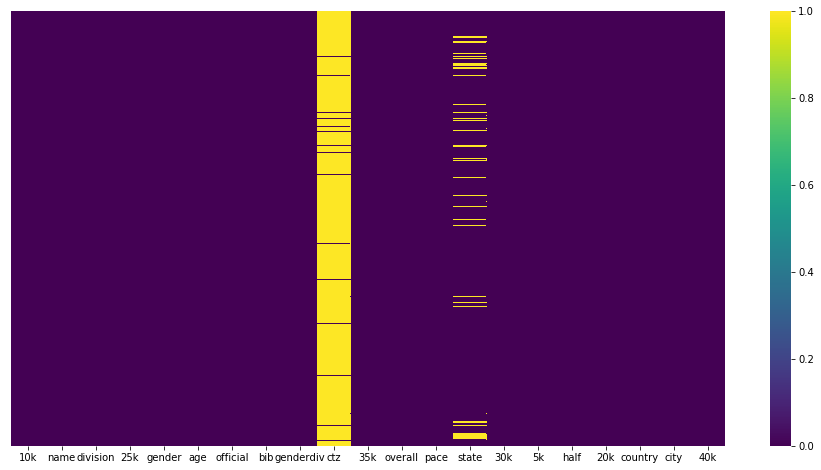

In [4]:
# View missing Data
plt.figure(figsize=(16,8))
sns.heatmap(df.isnull(), yticklabels=False, cmap='viridis')

In [5]:
df.drop(['name', 'bib', 'ctz', 'state'],1,inplace=True)

#Items to address
#1st out of order
#2nd are objects which means they are really mixed values and strings

In [6]:
# Re-Order Columns
df = df.reindex(['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k', 'official', 'pace', 'division', 'overall', 'genderdiv', 'gender', 'age', 'country', 'city'],axis=1)

df.head()

5k    10k    20k   half    25k    30k     35k     40k  official  pace  \
0   8.02  17.37  37.65  39.72  47.67  59.18   71.40   80.43     85.25  3.27   
1  16.22  32.58  65.83  69.47  82.43  99.33  116.37  132.10    138.95  5.30   
2   7.75  16.62  36.10  38.03  45.80  56.45   67.42   76.10     80.60  3.08   
3  16.20  32.57  65.83  69.47  82.43  99.33  116.37  132.95    140.58  5.37   
4   8.02  17.12  36.58  38.60  46.37  57.03   67.83   76.72     81.23  3.10   

   division  overall  genderdiv gender  age country            city  
0         8        8          8      M   47     JPN         Fukuoka  
1         1       21          1      F   33     KEN         Eldoret  
2         1        1          1      M   41     RSA           Paarl  
3         3       27          3      F   24     ETH            Shoa  
4         2        2          2      M   40     JPN  Nogata Fukuoka

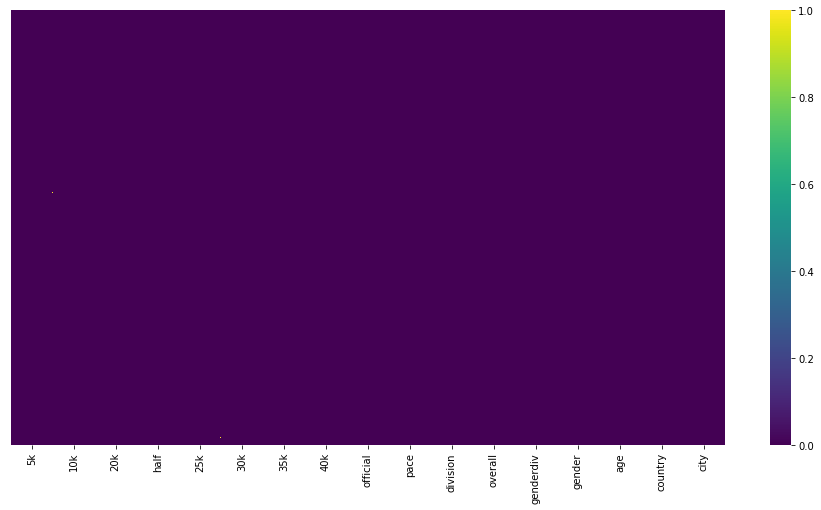

In [7]:
#There are runners that don't have splits, let's visually get a sense of that
#### This graph use to show what splits were missing

no_split = df.apply(lambda x: x.isin(['-']))

plt.figure(figsize=(16,8))
sns.heatmap(no_split, yticklabels=False, cmap='viridis')

In [8]:
print(no_split.sum(),no_split.sum().sum())
print('Percentage of missing splits {}%'.format(no_split.sum().sum()*100/(len(df)*8)))

5k            52
10k           50
20k           51
half          72
25k          216
30k           40
35k           34
40k           39
official       0
pace           0
division       0
overall        0
genderdiv      0
gender         0
age            0
country        0
city           0
dtype: int64 554
Percentage of missing splits 0.2165145072536268%


## Decisions, decisions, decisions

### Drop the missing data
Turn the missing splits to nulls and then drop them
Next turn those columns to numeric columns

### Impute the data
With respect to imputation here's what you shouldn't do
replace the values with 0s or median/mean values
Here is why, it's a race so imputing that data with mean values is the same as deleting them because the information is worthless

Let's Delete it.

In [9]:
# Lets replace all those strings and move on to what matters
df.replace('-',np.nan,inplace=True)

In [10]:
df.isnull().sum()

5k            52
10k           50
20k           51
half          72
25k          216
30k           40
35k           34
40k           39
official       0
pace           0
division       0
overall        0
genderdiv      0
gender         0
age            0
country        0
city           1
dtype: int64

In [11]:
df.dropna(inplace=True)

In [12]:
df.isnull().sum()

5k           0
10k          0
20k          0
half         0
25k          0
30k          0
35k          0
40k          0
official     0
pace         0
division     0
overall      0
genderdiv    0
gender       0
age          0
country      0
city         0
dtype: int64

In [13]:
df = df.apply(lambda x :pd.to_numeric(x,errors='ignore'))

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31648 entries, 0 to 31983
Data columns (total 17 columns):
5k           31648 non-null float64
10k          31648 non-null float64
20k          31648 non-null float64
half         31648 non-null float64
25k          31648 non-null float64
30k          31648 non-null float64
35k          31648 non-null float64
40k          31648 non-null float64
official     31648 non-null float64
pace         31648 non-null float64
division     31648 non-null int64
overall      31648 non-null int64
genderdiv    31648 non-null int64
gender       31648 non-null object
age          31648 non-null int64
country      31648 non-null object
city         31648 non-null object
dtypes: float64(10), int64(4), object(3)
memory usage: 4.3+ MB


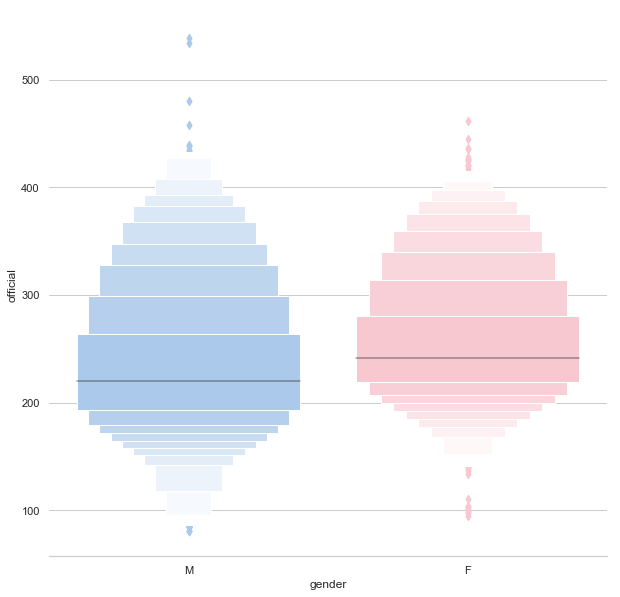

In [17]:
# Boxen Plot of Official Times for Men and Women
f, ax = plt.subplots(figsize=(10, 10))
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.boxenplot(x="gender", y= 'official',
              color="b", scale="linear", data=df, palette={"M": "b", "F": "pink"})
sns.despine(left=True)

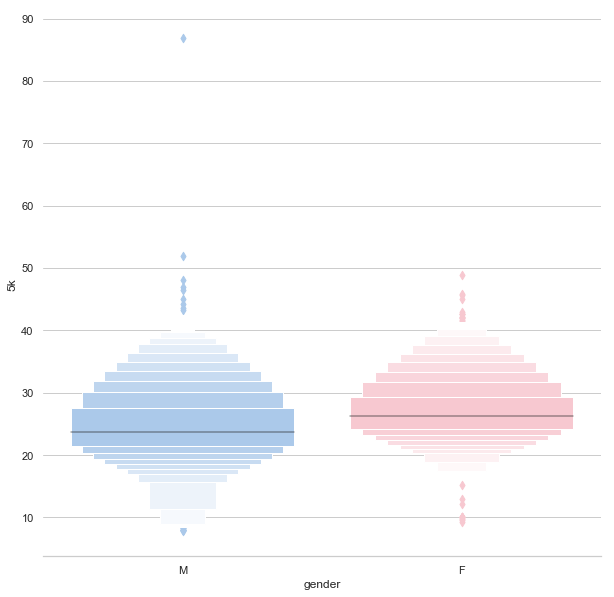

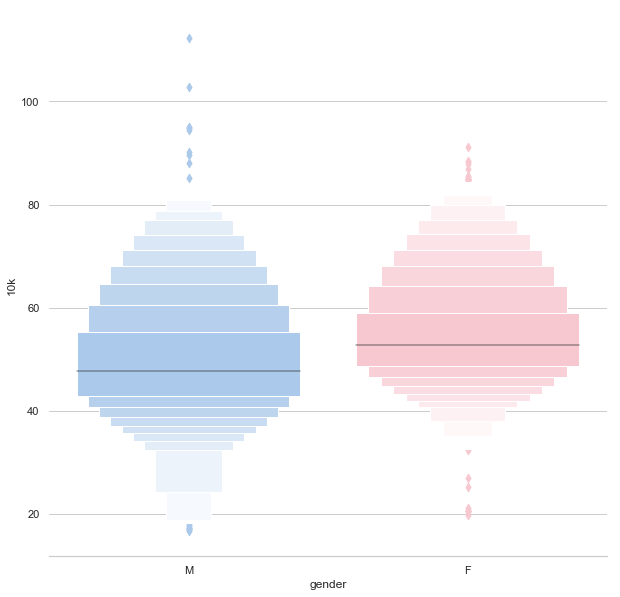

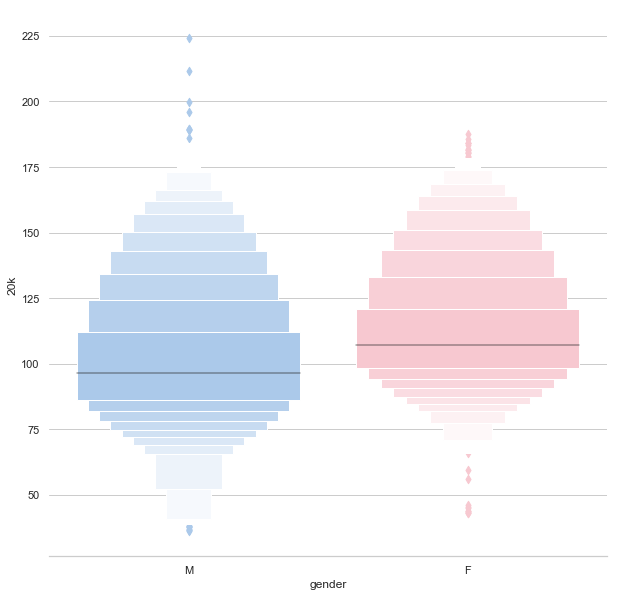

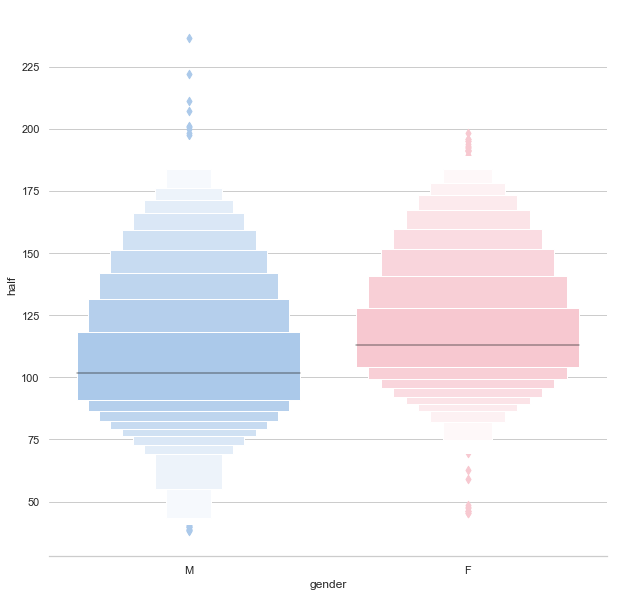

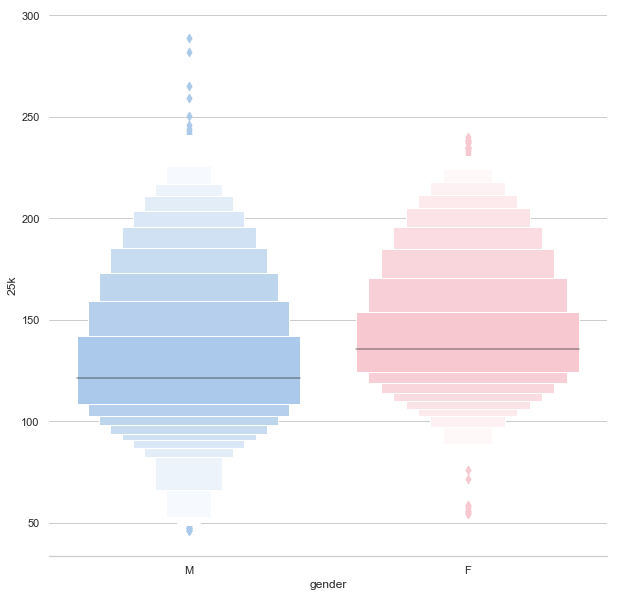

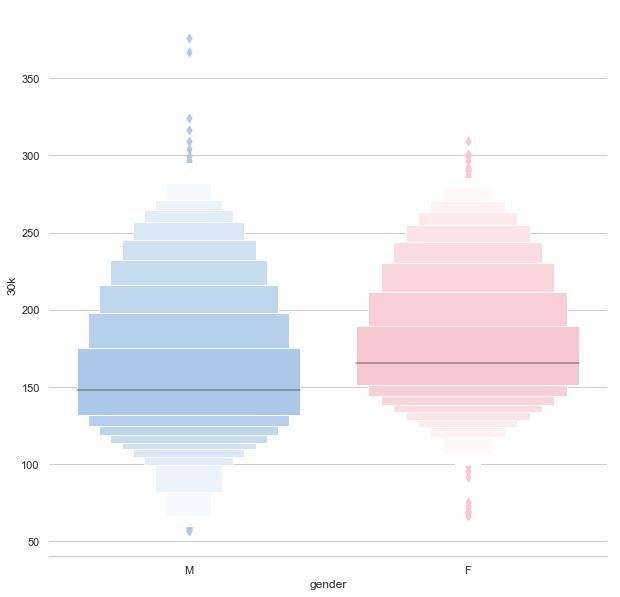

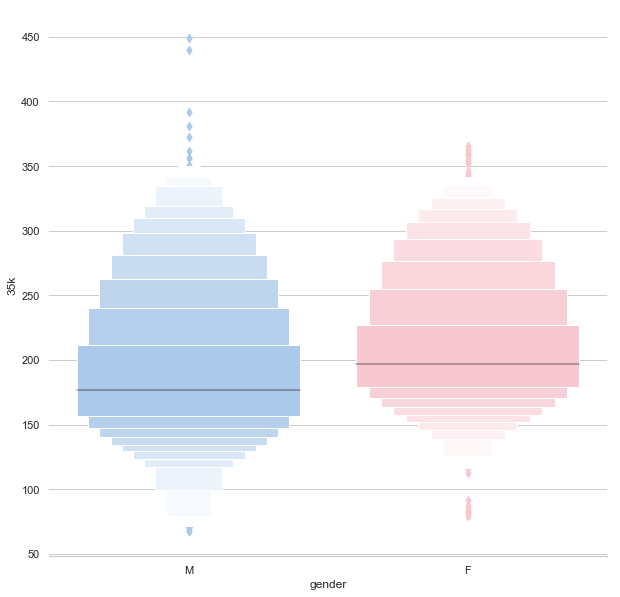

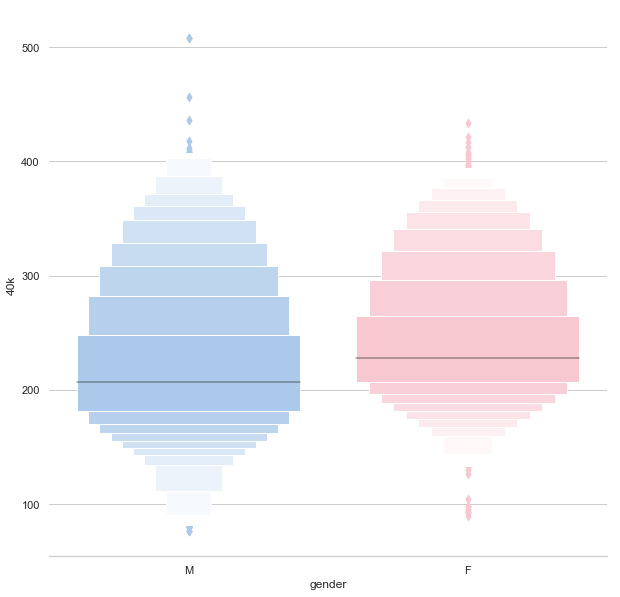

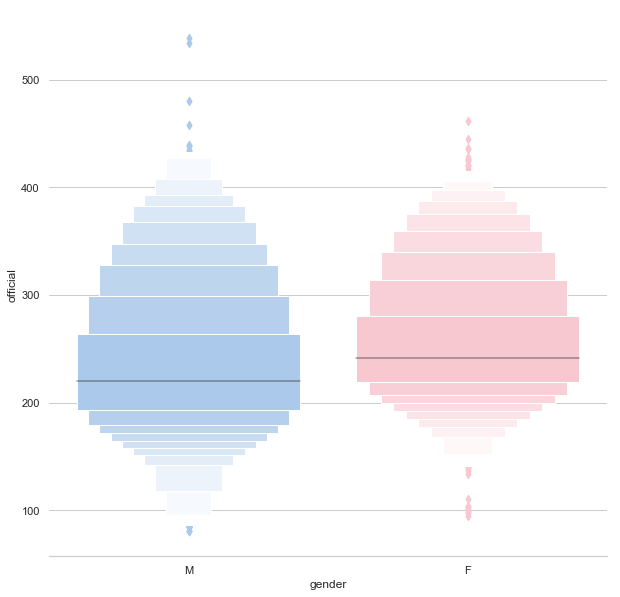

In [18]:
# Get all these graphs on the same axis and the "Boxenplots split on gender"
for col in df.columns[:-8]:
  f, ax = plt.subplots(figsize=(10, 10))
  sns.set(style="whitegrid", palette="pastel", color_codes=True)
  sns.boxenplot(x="gender", y= col, color="b", scale="linear", data=df, palette={"M": "b", "F": "pink"})
  sns.despine(left=True)

In [19]:
df.describe()

5k           10k           20k          half           25k  \
count  31648.000000  31648.000000  31648.000000  31648.000000  31648.000000   
mean      25.678275     51.629090    105.321547    111.211631    133.581381   
std        4.215447      8.710235     19.159786     20.306691     25.571858   
min        7.750000     16.620000     36.100000     38.030000     45.800000   
25%       22.620000     45.370000     91.670000     96.750000    115.430000   
50%       25.050000     50.280000    102.000000    107.680000    128.850000   
75%       28.400000     57.000000    116.150000    122.680000    147.700000   
max       86.950000    112.380000    224.350000    236.670000    289.020000   

                30k           35k           40k      official          pace  \
count  31648.000000  31648.000000  31648.000000  31648.000000  31648.000000   
mean     163.895155    196.033725    228.190455    241.952878      9.236483   
std       32.889838     40.775632     48.075181     50.843279      1.939178   
min       56.450000     67.420000     76.100000     80.600000      3.080000   
25%      140.515000    166.950000    193.620000    205.300000      7.830000   
50%      157.500000    187.850000    218.475000    231.980000      8.850000   
75%      182.200000    219.370000    256.570000    272.200000     10.380000   
max      376.380000    449.330000    508.350000    538.880000     20.570000   

           division       overall     genderdiv           age  
count  31648.000000  31648.000000  31648.000000  31648.000000  
mean    1922.800367  15834.008658   8003.025404     42.384700  
std     1704.844465   9182.364552   4733.295012     11.299784  
min        1.000000      1.000000      1.000000     18.000000  
25%      607.000000   7879.750000   3940.000000     33.000000  
50%     1418.000000  15829.500000   7919.000000     42.000000  
75%     2601.000000  23785.250000  11893.000000     50.000000  
max     6979.000000  31931.000000  17575.000000     81.000000

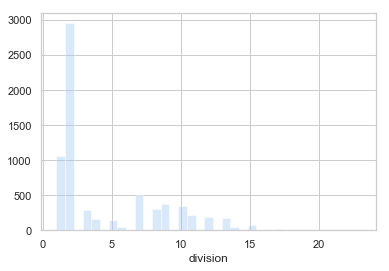

In [20]:
sns.distplot(df['division'].value_counts(),kde=False)

In [21]:
#Fastest official time was 128 minutes or 2 hours and 8 minutes. times lower than this are not considered
df = df[df['official']>=128]

In [22]:
df.head()

5k    10k    20k   half    25k    30k     35k     40k  official  pace  \
1  16.22  32.58  65.83  69.47  82.43  99.33  116.37  132.10    138.95  5.30   
3  16.20  32.57  65.83  69.47  82.43  99.33  116.37  132.95    140.58  5.37   
5  16.22  32.58  65.83  69.47  82.45  99.33  116.37  132.95    140.68  5.37   
7  15.17  30.48  61.62  64.85  76.95  92.52  107.47  122.80    129.83  4.97   
9  15.15  30.48  61.78  65.23  77.68  94.78  112.27  129.83    137.83  5.27   

   division  overall  genderdiv gender  age country         city  
1         1       21          1      F   33     KEN      Eldoret  
3         3       27          3      F   24     ETH         Shoa  
5         4       28          4      F   29     KEN        Nandi  
7         5        5          5      M   29     ETH  Addis Ababa  
9        20       20         20      M   31     USA      Redding

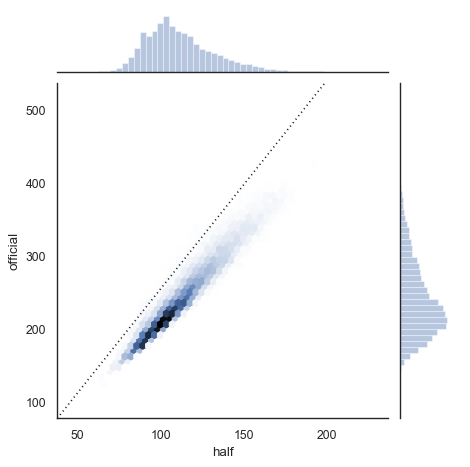

In [23]:
# This Graph shows where the halfway point in the group in regards to the finish line.

plt.style.use('classic')
sns.set()
with sns.axes_style('white'):
    g = sns.jointplot("half", "official", df ,kind='hex')
    g.ax_joint.plot(np.linspace(38, 198.6),
                    np.linspace(80.600000, 538.880000), ':k')

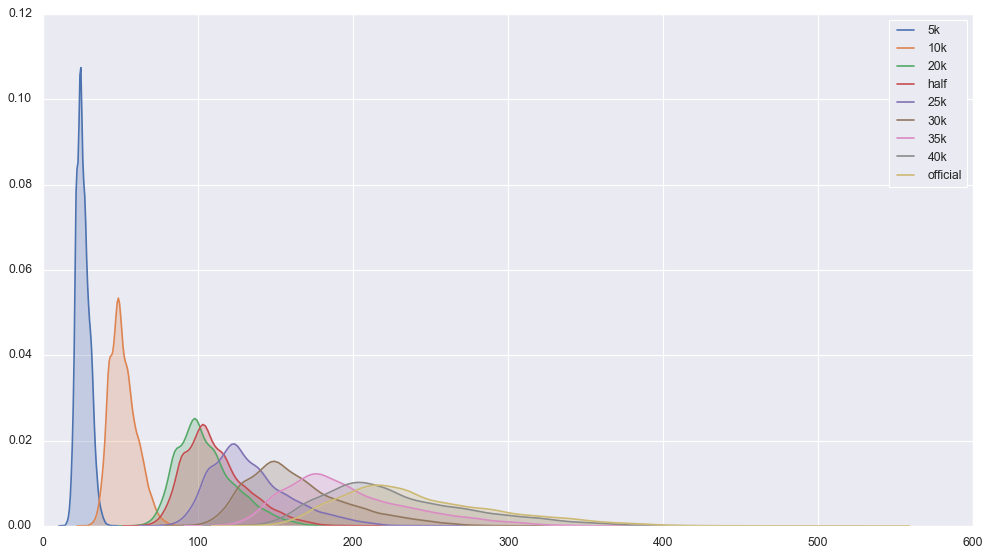

In [24]:
# here is a pacer graph based on start time
plt.subplots(figsize=(15, 8))
for col in df.columns[:-8] :
  sns.kdeplot(df[col], shade=True)

Feature Encoding 

In [25]:
df.head()

5k    10k    20k   half    25k    30k     35k     40k  official  pace  \
1  16.22  32.58  65.83  69.47  82.43  99.33  116.37  132.10    138.95  5.30   
3  16.20  32.57  65.83  69.47  82.43  99.33  116.37  132.95    140.58  5.37   
5  16.22  32.58  65.83  69.47  82.45  99.33  116.37  132.95    140.68  5.37   
7  15.17  30.48  61.62  64.85  76.95  92.52  107.47  122.80    129.83  4.97   
9  15.15  30.48  61.78  65.23  77.68  94.78  112.27  129.83    137.83  5.27   

   division  overall  genderdiv gender  age country         city  
1         1       21          1      F   33     KEN      Eldoret  
3         3       27          3      F   24     ETH         Shoa  
5         4       28          4      F   29     KEN        Nandi  
7         5        5          5      M   29     ETH  Addis Ababa  
9        20       20         20      M   31     USA      Redding

In [26]:
df.gender = np.where(df.gender == 'M',1,0)
df.country = df.country.astype('category')
df.country = df.country.cat.codes

df.city = df.city.astype('category')
df.city = df.city.cat.codes

## Clustering Methods


In [28]:

from sklearn.metrics import silhouette_score

df_normalize = StandardScaler().fit_transform(df)

C:\Users\postgres\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int8, int16, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\postgres\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int8, int16, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


# K-means 

### Elbow method and number of clusters

<function matplotlib.pyplot.show(*args, **kw)>

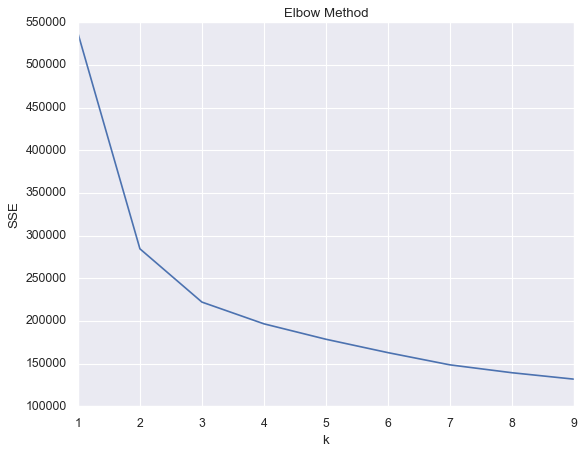

In [29]:
sse = {}
K = range(1,10)
for k in K:
    kmeanmodel = KMeans(n_clusters=k).fit(df_normalize)
    sse[k]= kmeanmodel.inertia_
    
# Plot
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show

In [30]:
for n_cluster in range(2, 7):
    kmeans = KMeans(n_clusters=n_cluster).fit(df_normalize)
    label = kmeans.labels_
    sil_coeff = silhouette_score(df, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.5013763730346547
For n_clusters=3, The Silhouette Coefficient is 0.4018000723497209
For n_clusters=4, The Silhouette Coefficient is 0.30518026903604356
For n_clusters=5, The Silhouette Coefficient is 0.2555787418168395
For n_clusters=6, The Silhouette Coefficient is 0.22941625543758154


For n_clusters above 2 seems to be the most ideal.

In [31]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(df_normalize)

In [33]:
df['y']=y_pred

C:\Users\postgres\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
C:\Users\postgres\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\postgres\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


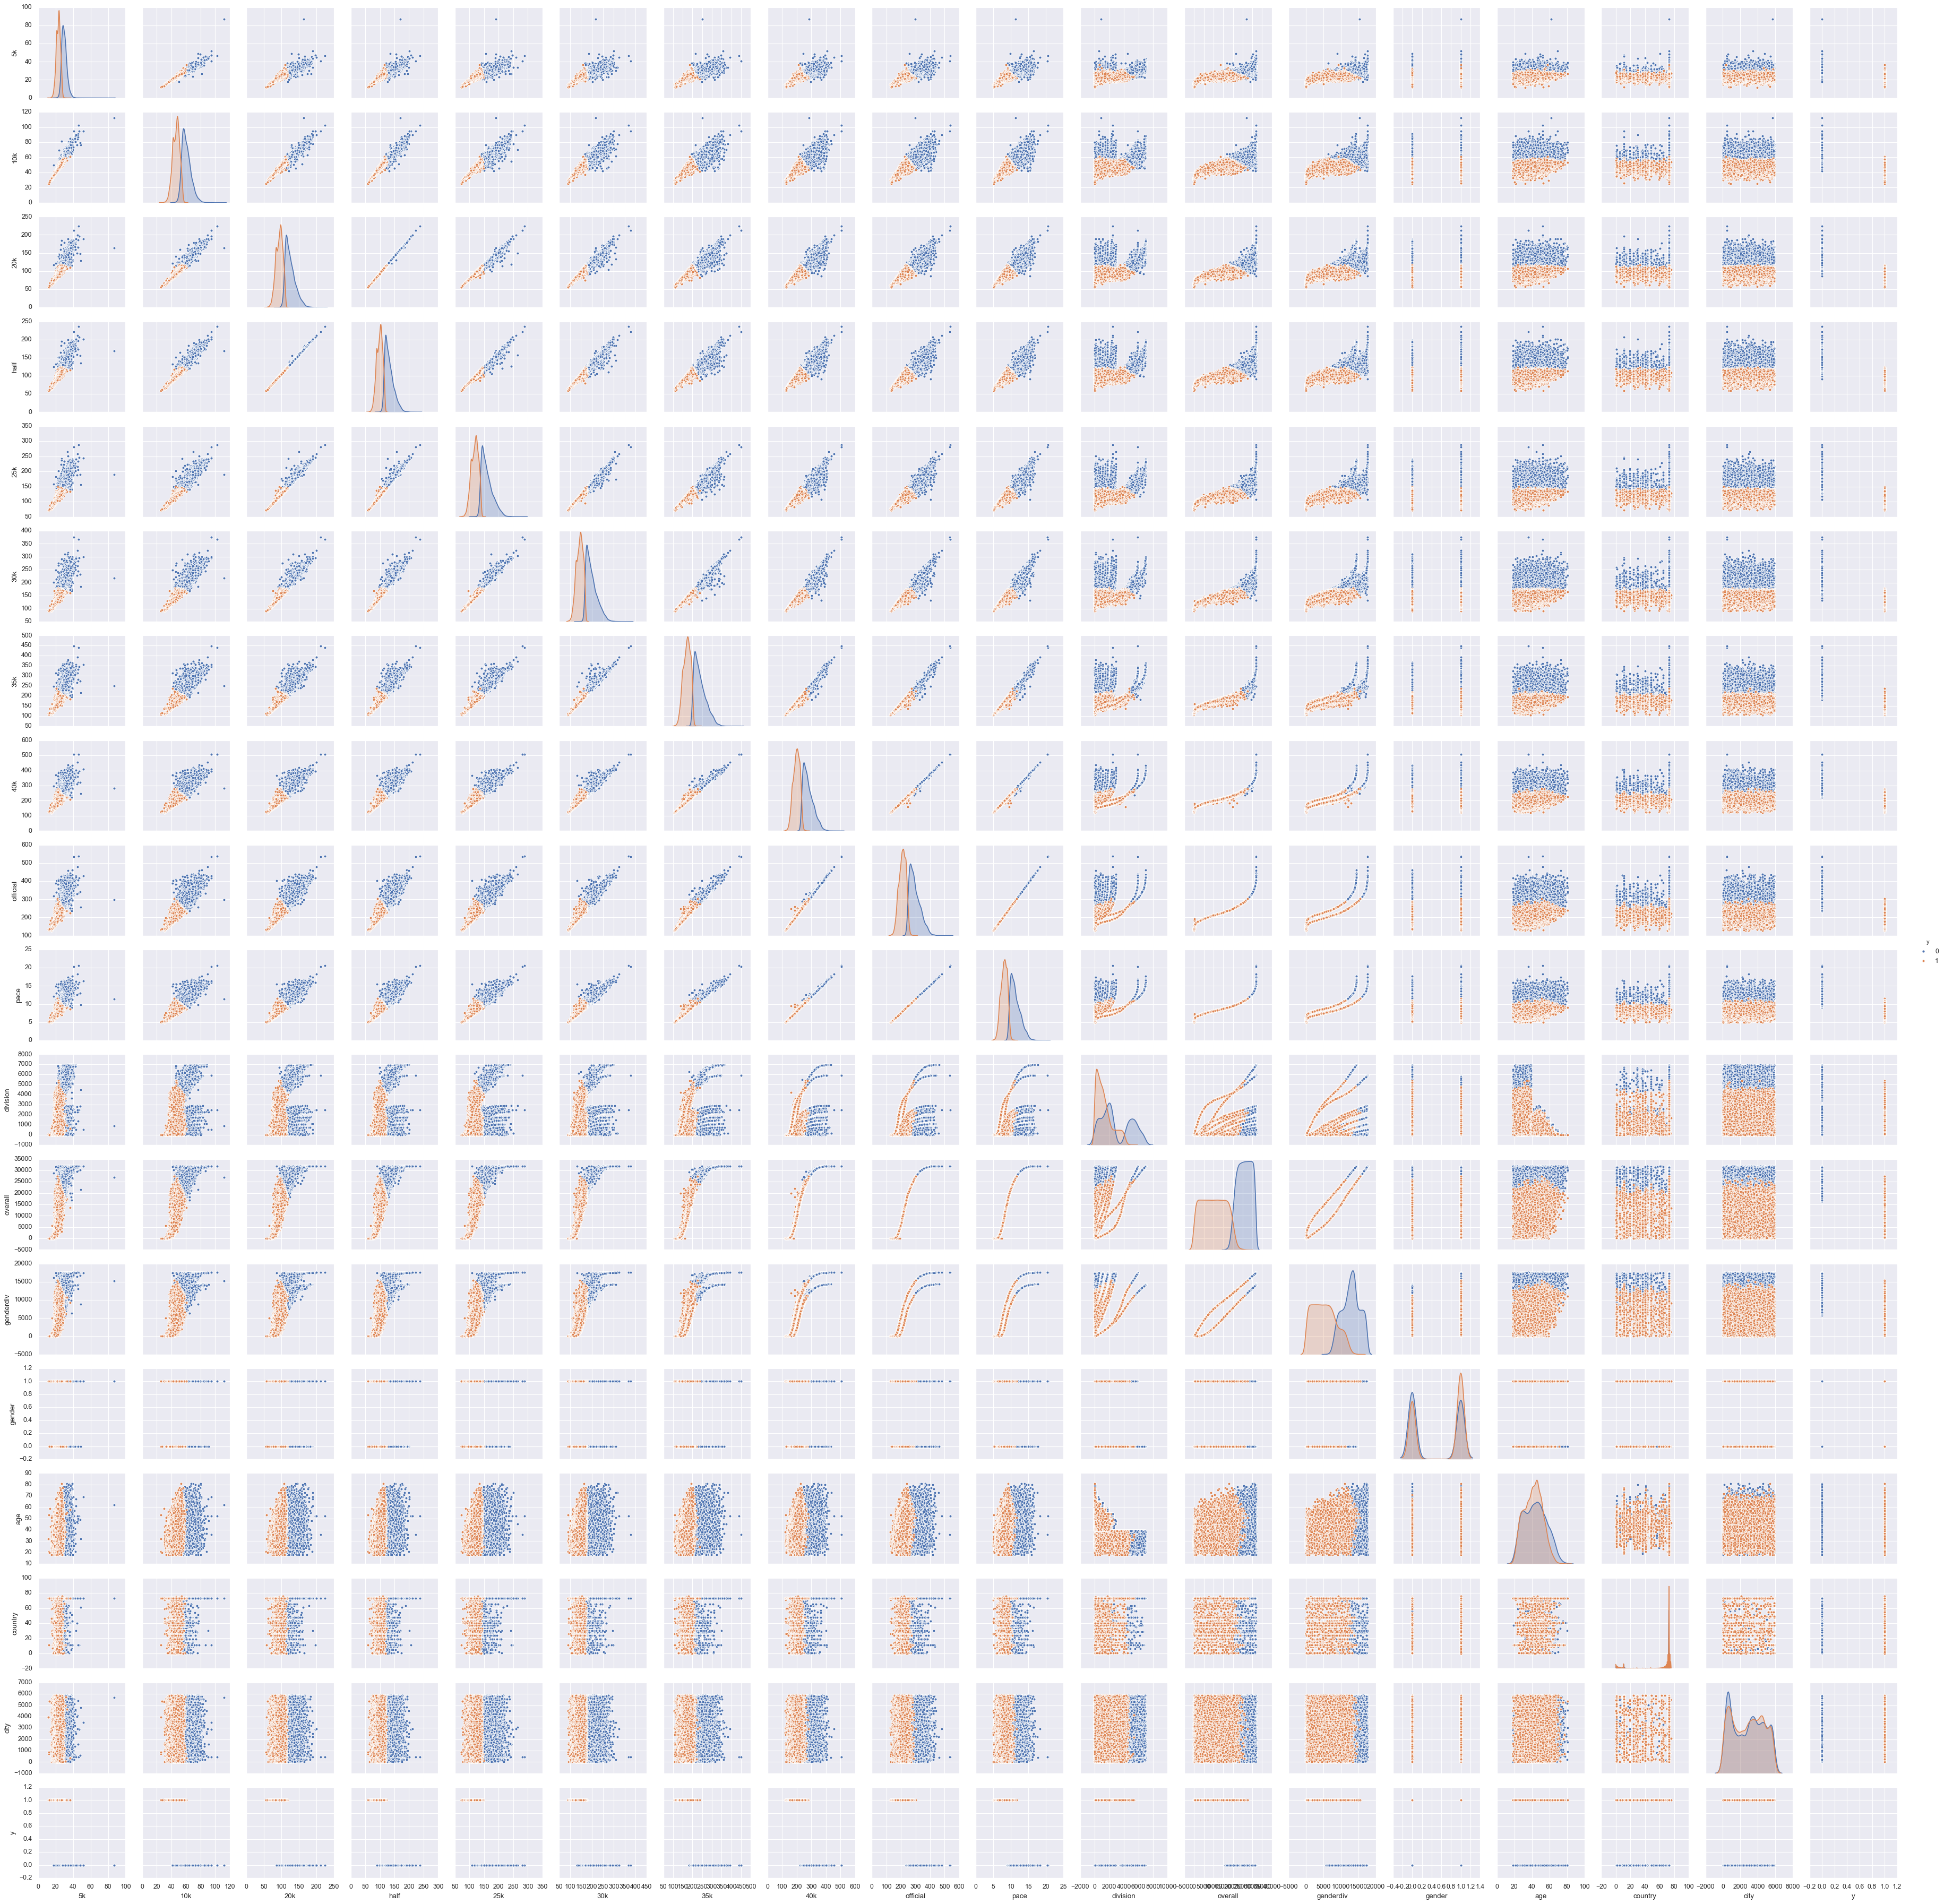

In [34]:
sns.pairplot(df, hue='y', size=2.5);

Inspecting the KDE plots above,

We can see that we have clustered between slower runners and faster runners.

Interesting features to note are

Division : The faster runner group is a lower division, perhaps suggesting that the race uses divison to group runners by their qualifying times.

Gender : There is a fair amount of overlap between the two clusters on gender, with men being slightly more favored than women

Age : The faster running group has a higher concentration of runners in their early 40s
City : Seems to play little role in chosing fast from slow runners